#### Thoughts

The difference in this competition is that, train contains feature but test contains only ID. 
- For non-time-based features (e.g. features from item name), some kind of mapping has to be created. 
- For time-based features, we should create lagged features on the entire labeled data available <strong> INCLUSIVE of the validation data </strong>, then train on train portion and and test on the validation portion.

#### Next step - set up a flexible training and validation process.
1. Time-based split of train & val - easy to change cut-off date
2. Train on train, val on val, and then train on the entire (train+val) and apply to test (to get submission to LB)
3. Easy to add time-based features (i.e. more lags)

##### And first baby-step of that...
1. Replicate previous_value_benchmark model
2. Add in one-hot month (non-time based) to capture seanality and see how much improvement we get
    - Other non-time features: similarity features from names?
3. Add in a couple lag1 features (time-based) to see how much improvement we get
    - by shop-item          
    - by shop
    - by item
    
#### Also keep in mind: Almost half of the shop-item combos in test are unseen in train, how to improve this?
    - Train a separate model on unseen?



In [1]:
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [3]:
from itertools import product # to expand month-shop-item combo

In [4]:
import pickle

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def rmse_clip(y_true, y_pred):
    y_pred = y_pred.clip(0,20)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return(rmse)

### Read in Data

In [204]:
train = pd.read_csv(r'../data/sales_train.csv.gz')
train.shape

(2935849, 6)

In [205]:
train[:3]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [206]:
test = pd.read_csv(r'../data/test.csv.gz')

In [207]:
test[:3]

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


#### Check what is in other data

In [11]:
# items0 = pd.read_csv(r'../data/items.csv')
# shops0 = pd.read_csv(r'../data/shops.csv')
# item_cat0 = pd.read_csv(r'../data/item_categories.csv')
# items0[:3] # ok contains name of the item/cat/shop; ABBYY FineReader??

In [12]:
train[(train.shop_id==25)&(train.item_id==2552)]  
# looks like return. looks like negative rows should be removed
# Or make a "returned?" feature

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [13]:
(train['item_cnt_day']==0).sum()

0

In [14]:
train2 = train[train.item_cnt_day>0]
# train2 = train[(train.item_cnt_day>0) & train.shop_id.isin(test.shop_id.unique())]

print(train2.shape)

train2['date2'] = pd.to_datetime(train2['date'],format='%d.%m.%Y')
train2.drop(labels='date',axis=1,inplace=True)

# print(train2.shop_id.nunique())
# pickle.dump(train2,open(r'../data2/train_42shops.pkl','wb'))
del train

(2928493, 6)


### Aggregate sale by month

In [15]:
train2.sort_values(by=['date_block_num','shop_id','item_id','date2'],inplace=True)
monthly_sales = train2.groupby(['date_block_num','shop_id','item_id'])\
    .agg({'item_cnt_day':'sum'}).reset_index()
#     .agg({'item_cnt_day':'sum','item_price':['first','mean','last']})\
#     .reset_index()
monthly_sales[:3]

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0


In [16]:
monthly_sales['shop_item'] = monthly_sales['shop_id'].astype(str)+ '-' + monthly_sales['item_id'].astype(str)

In [17]:
monthly_sales.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
# monthly_sales.columns = monthly_sales.columns.droplevel(1)
# monthly_sales.columns = ['date_block_num', 'month', 'shop_id', 'item_id', 'item_cnt_month','f_p','m_p','l_p']
# monthly_sales[:3]

In [18]:
del train2

### Set up time-based train-test split

In [19]:
hold_out_month = 33
val = monthly_sales.loc[monthly_sales.date_block_num==hold_out_month,['date_block_num','shop_id','item_id','shop_item','item_cnt_month']]

<strong>Since we have lag features, we are just going to build the features on entire monthly_sales data w/o spliting monthly_sales and X_val. 
    
However, make sure we do feature selection only on the monthly_sales portion (where date_block_num < hold_out_month </strong>

In [20]:
monthly_sales[:3]

,date_block_num,shop_id,item_id,item_cnt_month,shop_item
0,0,0,32,6.0,0-32
1,0,0,33,3.0,0-33
2,0,0,35,1.0,0-35


In [21]:
val['shop_item'].isin(monthly_sales.loc[monthly_sales.date_block_num < hold_out_month,'shop_item'].unique()).sum()  # 7,000 (>20% unseen)

24401

### Expand month, shop_id, item_id combo to facilitate time-based feature building

Found out I need this when trying to build time-series based feature (damn it)

In [22]:
shops_in_tr = monthly_sales.shop_id.unique()
items_in_tr = monthly_sales.item_id.unique()
months_in_tr = monthly_sales.date_block_num.unique()
print(len(shops_in_tr),len(items_in_tr),len(months_in_tr))

60 21804 34


In [23]:
grid = np.array(list(product(*[shops_in_tr,items_in_tr,months_in_tr])),dtype='int32')
grid.shape

(44480160, 3)

In [24]:
grid = pd.DataFrame(grid,columns=['shop_id','item_id','date_block_num'],dtype='int32')

In [25]:
monthly_sales_all = pd.merge(grid,monthly_sales[['shop_id','item_id','date_block_num','item_cnt_month']],how='left')
print(monthly_sales_all.shape)
monthly_sales_all[:3]

(44480160, 4)


,shop_id,item_id,date_block_num,item_cnt_month
0,0,32,0,6.0
1,0,32,1,10.0
2,0,32,2,NaN


In [26]:
del grid

In [27]:
%%time
# monthly_sales_all.loc[:,'month'] = np.mod(monthly_sales_all['date_block_num'],12) + 1
# monthly_sales_all.loc[:,'shop_item'] = monthly_sales_all['shop_id'].astype(str) + "-" + monthly_sales_all['item_id'].astype(str)
monthly_sales_all.loc[:,'item_cnt_month'].fillna(0,inplace=True)

Wall time: 112 ms


### Start building features

In [28]:
n_lags = 2

In [29]:
def generate_lags(data, group_by,target, prefix, n_lags):
    feats = []
    for i in range(n_lags):
        feats.append(data.groupby(group_by)[target].shift(i+1))
        
    all_feats = pd.concat(feats,axis=1)
    all_feats.columns = [prefix + str(i+1) for i in range(n_lags)]

    return(pd.concat([data,all_feats],axis=1))

In [30]:
%%time
monthly_sales_all.sort_values(by=['shop_id','item_id','date_block_num'],ascending=[True,True,True],inplace=True)

Wall time: 15.4 s


In [31]:
%%time
sh_it_lags = generate_lags(monthly_sales_all,group_by=['shop_id','item_id'],target='item_cnt_month',prefix='sh_it_cnt_lg',n_lags=n_lags)

Wall time: 11.2 s


In [38]:
del monthly_sales_all

#### Predict w lag v RF w lag

In [32]:
val2 = pd.merge(val, sh_it_lags.loc[sh_it_lags.date_block_num==32,['shop_id','item_id','sh_it_cnt_lg1','sh_it_cnt_lg2']],how='left', on = ['shop_id','item_id'])
val2[:3]

,date_block_num,shop_id,item_id,shop_item,item_cnt_month,sh_it_cnt_lg1,sh_it_cnt_lg2
0,33,2,31,2-31,1.0,0.0,0.0
1,33,2,486,2-486,3.0,0.0,0.0
2,33,2,787,2-787,1.0,0.0,0.0


#### Predict w lg1 vs. Predict w lg1 + lg2

In [33]:
rmse_clip(y_true = val2.item_cnt_month,y_pred = val2.sh_it_cnt_lg1)

14.409485083309018

In [34]:
rmse_clip(y_true = val2.item_cnt_month,y_pred = (val2.sh_it_cnt_lg2+val2.sh_it_cnt_lg1)/2)

14.38818500392745

#### Now test a linear model w lg1 + lg2 & seasonality

In [36]:
sh_it_lags['month'] = np.mod(sh_it_lags.date_block_num,12) + 1
sh_it_lags[:3]

,shop_id,item_id,date_block_num,item_cnt_month,sh_it_cnt_lg1,sh_it_cnt_lg2,month
594048,0,0,0,0.0,NaN,NaN,1
594049,0,0,1,0.0,0.0,NaN,2
594050,0,0,2,0.0,0.0,0.0,3


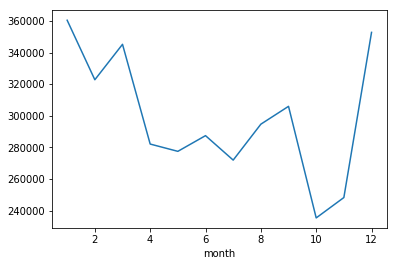

In [37]:
sh_it_lags[sh_it_lags.date_block_num<hold_out_month].groupby(['month'])['item_cnt_month'].sum().plot() # clear seasonality

- <strong>One-hot encode month</strong>

In [39]:
enc = OneHotEncoder()

In [40]:
m_onehot = enc.fit_transform(pd.Series(list(range(1,13))).reshape(-1,1)).toarray()
m_onehot.shape
# 12 levels -> 12 features, need to drop 1 to avoid multicolinearity (since we are first going to fit a linear model)

# reshape(-1,1) -1 means unknown dimension which we just let numpy to figure out
# since OneHotEncoder() takes 2-D array, we need to make our 1D series into a 2-D matrix format
# we know there is one column, and let numpy to figure out how many rows there should be
# <=> reshape.(rows_in_your_data,1)

(12, 12)

In [41]:
m_onehot_df = pd.DataFrame(np.hstack((np.array(range(1,13)).reshape(12,1),m_onehot[:,1:])), columns=['month']+['m'+str(i) for i in range(2,13)])
m_onehot_df

,month,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [42]:
all_feat = pd.merge(sh_it_lags,m_onehot_df,on=['month'],how='left')
all_feat[:3]

,shop_id,item_id,date_block_num,item_cnt_month,sh_it_cnt_lg1,sh_it_cnt_lg2,month,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0,0,0,0.0,NaN,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0.0,0.0,NaN,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,2,0.0,0.0,0.0,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
del sh_it_lags

In [77]:
X_tr = all_feat.loc[(all_feat.date_block_num < hold_out_month) & (all_feat.date_block_num>=n_lags) & (all_feat.item_cnt_month>0),
                    ['sh_it_cnt_lg1','sh_it_cnt_lg2','item_cnt_month']+['m'+str(i) for i in range(2,13)]]
print(X_tr.shape)
X_tr[:3]

(1453624, 14)


,sh_it_cnt_lg1,sh_it_cnt_lg2,item_cnt_month,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
1483607,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1483694,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1483697,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
lm = LinearRegression()

In [79]:
lm.fit(X_tr.drop(labels='item_cnt_month',axis=1),X_tr.item_cnt_month)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [80]:
val2 = all_feat.loc[(all_feat.date_block_num < hold_out_month) & (all_feat.date_block_num>=n_lags) & (all_feat.item_cnt_month>0),
                    ['sh_it_cnt_lg1','sh_it_cnt_lg2','item_cnt_month']+['m'+str(i) for i in range(2,13)]]

In [81]:
y_pred = lm.predict(val2.drop(labels=['item_cnt_month'],axis=1)).flatten()
rmse_clip(val2.item_cnt_month , y_pred)
# WOW significantly improved!

8.372234504960494

### Create a new submission

In [184]:
def generate_lags_for_test(data,old_var_name,new_var_pre,n_lags):
    
    # make sure it's properly sorted
    data.sort_values(by=['shop_id','item_id'],inplace=True)
    
    months = [33 - n for n in range(n_lags)]
    dfs=[]
    for m in months:
        df = data.loc[data.date_block_num == m, old_var_name].reset_index(drop=True)
        dfs.append(df)
        
    all_feats = pd.concat(dfs,axis=1,ignore_index=True)
    all_feats.columns = [new_var_pre + str(n+1) for n in range(n_lags)]
    
    return(pd.concat([data.loc[data.date_block_num == months[0],['shop_id','item_id']].reset_index(drop=True), all_feats], axis=1))

In [185]:
test_lags = generate_lags_for_test(all_feat,'item_cnt_month','sh_it_cnt_lg',2)
print(test_lags.shape)
test_lags[:3]

(1308240, 4)


,shop_id,item_id,sh_it_cnt_lg1,sh_it_cnt_lg2
0,0,0,0.0,0.0
1,0,1,0.0,0.0
2,0,2,0.0,0.0


In [187]:
test_m_onehot = np.zeros((len(test),11))
test_m_onehot[:,9] = 1
test_m_onehot = pd.DataFrame(test_m_onehot, columns=["m"+str(i) for i in range(2,13)])
test_m_onehot[:3]

,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [219]:
test_feats = pd.merge(test,test_lags,how='left',on=['shop_id','item_id'])
test_feats = pd.concat([test_feats,test_m_onehot],axis=1)
print(test_feats.shape)
test_feats[:3]

(214200, 16)


,ID,shop_id,item_id,sh_it_cnt_lg1,sh_it_cnt_lg2,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,0,5,5037,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,5,5320,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,5,5233,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [220]:
test_feats.loc[(test_feats.sh_it_cnt_lg1==0) & (test_feats.sh_it_cnt_lg2==0),['sh_it_cnt_lg1','sh_it_cnt_lg2']] = np.nan

In [221]:
print(test_feats.sh_it_cnt_lg1.isnull().sum())
# test_feats.fillna(0,inplace=True)

170459


In [230]:
test_model = test_feats[test_feats.sh_it_cnt_lg1.notnull()]
test_model['item_cnt_month'] = lm.predict(test_model.drop(labels=['ID','shop_id','item_id'],axis=1)).clip(0,20)
test_na = test_feats[test_feats.sh_it_cnt_lg1.isnull()]
test_na['item_cnt_month'] = 0

In [233]:
test_model[:3]

,ID,shop_id,item_id,sh_it_cnt_lg1,sh_it_cnt_lg2,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,item_cnt_month
0,0,5,5037,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.604909
2,2,5,5233,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.638505
5,5,5,5039,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.143151


In [231]:
# test['item_cnt_month'] = lm.predict(test_feats.drop(labels=['ID','shop_id','item_id'],axis=1))
# test['item_cnt_month'] = test['item_cnt_month'].clip(0,20)
test_model['item_cnt_month'].describe()

count    43741.000000
mean         2.357230
std          1.665818
min          1.604909
25%          1.604909
50%          1.895474
75%          2.390828
max         20.000000
Name: item_cnt_month, dtype: float64

In [234]:
pd.concat([test_model[['ID','item_cnt_month']],test_na[['ID','item_cnt_month']]])\
           .to_csv(r'../output/7_1004_lm_2lg_onehot m_v2.csv',index=False)

- <strong> Time series</strong>
    1. Create a shop-item lag
    2. Create a shop lag (mean encoding)
    3. Create an item lag (mean encoding)

337060


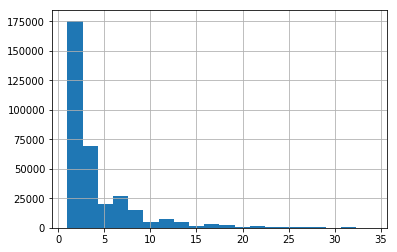

In [155]:
# Get check on average how many months of data does each shop-item have
print(monthly_sales_all[monthly_sales_all.item_cnt_month>0].shop_item.nunique())
monthly_sales_all[monthly_sales_all.item_cnt_month>0].sort_values(by=['shop_item','date_block_num']).groupby(['shop_item'])['date_block_num'].count().hist(bins=20) 
# ~ half has only 1 data point

In [156]:
monthly_sales_all[:3]

,shop_id,item_id,date_block_num,item_cnt_month,shop_item,month
0,2,27,0,1.0,2-27,1
1,2,27,1,0.0,2-27,2
2,2,27,2,0.0,2-27,3


-  shop-item lag

In [157]:
monthly_sales_all.sort_values(by=['shop_item','date_block_num'],inplace=True)
monthly_sales_all['sh_it_cnt_lag1'] = monthly_sales_all.groupby('shop_item')['item_cnt_month'].shift(1)
monthly_sales_all['sh_it_cnt_lag2'] = monthly_sales_all.groupby('shop_item')['item_cnt_month'].shift(2)
monthly_sales_all[:3]

,shop_id,item_id,date_block_num,item_cnt_month,shop_item,month,sh_it_cnt_lag1,sh_it_cnt_lag2
4095300,10,1,0,0.0,10-1,1,NaN,NaN
4095301,10,1,1,0.0,10-1,2,0.0,NaN
4095302,10,1,2,0.0,10-1,3,0.0,0.0


In [158]:
# check how strong the correlation is
temp = monthly_sales_all[(monthly_sales_all.item_cnt_month>0) & (monthly_sales_all.sh_it_cnt_lag1.notnull()) & (monthly_sales_all.sh_it_cnt_lag2.notnull())]
temp[['item_cnt_month','sh_it_cnt_lag1','sh_it_cnt_lag2']].corr()

,item_cnt_month,sh_it_cnt_lag1,sh_it_cnt_lag2
item_cnt_month,1.000000,0.640120,0.554115
sh_it_cnt_lag1,0.640120,1.000000,0.688328
sh_it_cnt_lag2,0.554115,0.688328,1.000000


- shop_lag

In [159]:
by_shop = monthly_sales_all.groupby(['date_block_num','shop_id'])['item_cnt_month'].agg(['sum','mean']).reset_index()
by_shop.rename(columns={'sum':'sh_sum_items','mean':'sh_mean_items'},inplace=True)
print(by_shop.shape)
by_shop[:3]

(1428, 4)


,date_block_num,shop_id,sh_sum_items,sh_mean_items
0,0,2,1151.0,0.054807
1,0,3,767.0,0.036522
2,0,4,2117.0,0.100805


In [160]:
n_items = monthly_sales_all[monthly_sales_all.item_cnt_month>0].groupby(['date_block_num','shop_id'])['item_id'].agg(pd.Series.nunique).reset_index()
n_items.rename(columns={'item_id':'sh_n_items'},inplace=True)
print(n_items.shape)
n_items[:3]

(1327, 3)


,date_block_num,shop_id,sh_n_items
0,0,2,728
1,0,3,544
2,0,4,1061


In [161]:
by_shop2 = pd.merge(by_shop,n_items,how='left')
by_shop2.sh_n_items.fillna(0,inplace=True)
print(by_shop2.shape)
by_shop2[:3]

(1428, 5)


,date_block_num,shop_id,sh_sum_items,sh_mean_items,sh_n_items
0,0,2,1151.0,0.054807,728.0
1,0,3,767.0,0.036522,544.0
2,0,4,2117.0,0.100805,1061.0


In [162]:
by_shop2.sort_values(by=['shop_id','date_block_num'],inplace=True)
by_shop2[['sh_mean_items_lag1','sh_n_items_lag1','sh_sum_items_lag1']] = by_shop2.groupby('shop_id')['sh_mean_items','sh_n_items','sh_sum_items'].shift(1)
by_shop2[['sh_mean_items_lag2','sh_n_items_lag2','sh_sum_items_lag2']] = by_shop2.groupby('shop_id')['sh_mean_items','sh_n_items','sh_sum_items'].shift(2)
by_shop2[:3]

,date_block_num,shop_id,sh_sum_items,sh_mean_items,sh_n_items,sh_mean_items_lag1,sh_n_items_lag1,sh_sum_items_lag1,sh_mean_items_lag2,sh_n_items_lag2,sh_sum_items_lag2
0,0,2,1151.0,0.054807,728.0,NaN,NaN,NaN,NaN,NaN,NaN
42,1,2,489.0,0.023285,323.0,0.054807,728.0,1151.0,NaN,NaN,NaN
84,2,2,756.0,0.035998,428.0,0.023285,323.0,489.0,0.054807,728.0,1151.0


- By item

In [163]:
by_item = monthly_sales_all.groupby(['date_block_num','item_id'])['item_cnt_month'].agg(['sum','mean']).reset_index()
by_item.rename(columns={'sum':'it_sum_items','mean':'it_mean_items'},inplace=True)
print(by_item.shape)
by_item[:3]

(714034, 4)


,date_block_num,item_id,it_sum_items,it_mean_items
0,0,1,0.0,0.0
1,0,16,0.0,0.0
2,0,17,0.0,0.0


In [164]:
n_shops = monthly_sales_all[monthly_sales_all.item_cnt_month>0].groupby(['date_block_num','item_id'])['shop_id'].agg(pd.Series.nunique).reset_index()
n_shops.rename(columns={'shop_id':'it_n_shops'},inplace=True)
print(n_shops.shape)
n_shops[:3]

(221871, 3)


,date_block_num,item_id,it_n_shops
0,0,19,1
1,0,27,6
2,0,28,5


In [165]:
by_items2=pd.merge(by_item,n_shops,how='left')
by_items2['it_n_shops'].fillna(0,inplace=True)
by_items2[:3]

,date_block_num,item_id,it_sum_items,it_mean_items,it_n_shops
0,0,1,0.0,0.0,0.0
1,0,16,0.0,0.0,0.0
2,0,17,0.0,0.0,0.0


In [166]:
by_items2.sort_values(by=['item_id','date_block_num'],inplace=True)
by_items2[['it_mean_items_lag1','it_n_shops_lag1','it_sum_items_lag1']] = by_items2.groupby('item_id')['it_mean_items','it_n_shops','it_sum_items'].shift(1)
by_items2[['it_mean_items_lag2','it_n_shops_lag2','it_sum_items_lag2']] = by_items2.groupby('item_id')['it_mean_items','it_n_shops','it_sum_items'].shift(2)
by_items2[by_items2.item_id==27][:3]

,date_block_num,item_id,it_sum_items,it_mean_items,it_n_shops,it_mean_items_lag1,it_n_shops_lag1,it_sum_items_lag1,it_mean_items_lag2,it_n_shops_lag2,it_sum_items_lag2
6,0,27,6.0,0.142857,6.0,NaN,NaN,NaN,NaN,NaN,NaN
21007,1,27,3.0,0.071429,3.0,0.142857,6.0,6.0,NaN,NaN,NaN
42008,2,27,3.0,0.071429,3.0,0.071429,3.0,3.0,0.142857,6.0,6.0


In [167]:
by_items2[['it_sum_items','it_n_shops']].corr()

,it_sum_items,it_n_shops
it_sum_items,1.000000,0.376857
it_n_shops,0.376857,1.000000


In [168]:
del by_item
del by_shop
del n_shops
del n_items

### Merge all the features together

In [169]:
monthly_sales_all[:3]

,shop_id,item_id,date_block_num,item_cnt_month,shop_item,month,sh_it_cnt_lag1,sh_it_cnt_lag2
4095300,10,1,0,0.0,10-1,1,NaN,NaN
4095301,10,1,1,0.0,10-1,2,0.0,NaN
4095302,10,1,2,0.0,10-1,3,0.0,0.0


In [171]:
%%time
temp = pd.merge(monthly_sales_all[monthly_sales_all.item_cnt_month>0],month_one_hot_df,left_index=True,right_index=True)
temp = pd.merge(temp, by_shop2,on=['shop_id','date_block_num'],how='left')
temp = pd.merge(temp, by_items2,on=['item_id','date_block_num'],how='left')
print(temp.shape)

(1323030, 37)
Wall time: 13.9 s


In [102]:
# Thru the corr heatmap below, lag2s tend to highly correlate with lag1s
# sum & mean are also highly correlated
ft_tr = ['sh_it_cnt_lag1', 'sh_it_cnt_lag2',
         'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
         'sh_mean_items_lag1', #'sh_n_items_lag1', 'sh_sum_items_lag1', 
         #'sh_mean_items_lag2', 'sh_n_items_lag2', 'sh_sum_items_lag2', 
         'it_mean_items_lag1', 'it_n_shops_lag1', #'it_sum_items_lag1', 
         #'it_mean_items_lag2', 'it_n_shops_lag2', 'it_sum_items_lag2'
        ]

In [172]:
monthly_sales_final = temp.loc[temp.date_block_num<hold_out_month,ft_tr]
y_tr_final = temp.loc[temp.date_block_num<hold_out_month,'item_cnt_month']
monthly_sales_final[:3]

,sh_it_cnt_lag1,sh_it_cnt_lag2,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,sh_mean_items_lag1,it_mean_items_lag1,it_n_shops_lag1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.038093,0.142857,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032522,0.214286,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.035951,0.285714,11.0


In [173]:
monthly_sales_final.fillna(0,inplace=True)

In [174]:
corr = monthly_sales_final.corr()
corr[corr>0.7]

,sh_it_cnt_lag1,sh_it_cnt_lag2,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,sh_mean_items_lag1,it_mean_items_lag1,it_n_shops_lag1
sh_it_cnt_lag1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sh_it_cnt_lag2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m4,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m6,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
m9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


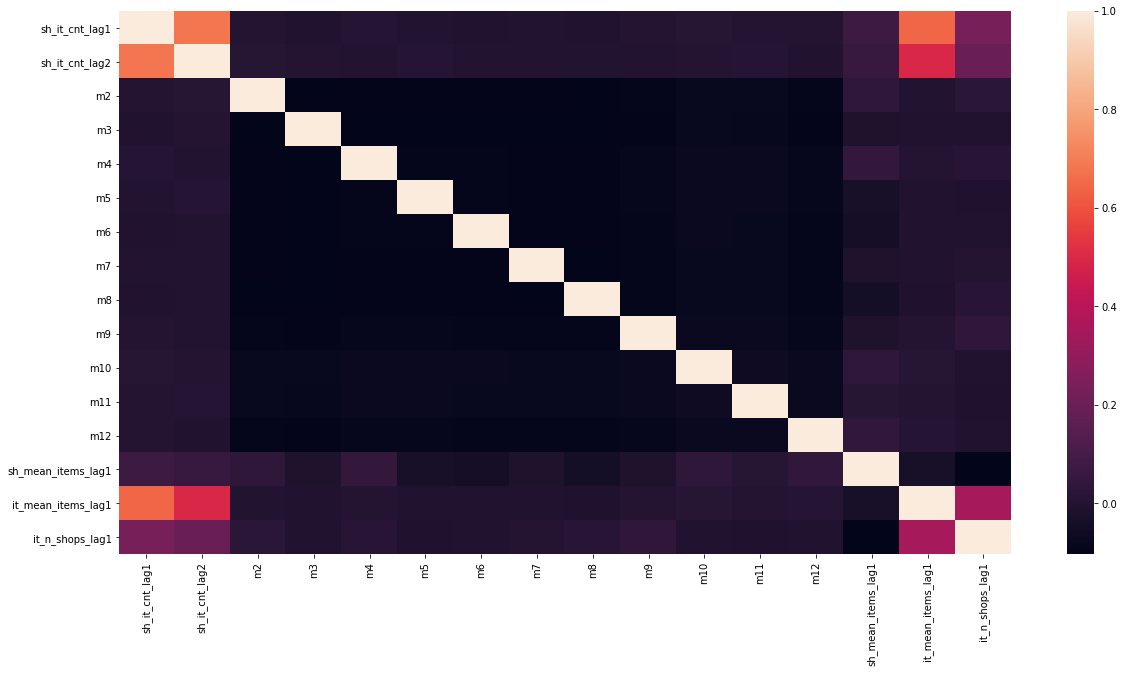

In [175]:
plt.figure(figsize=(20,10))
sns.heatmap(corr)

In [176]:
lm = LinearRegression()

In [178]:
lm.fit(monthly_sales_final,y_tr_final)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [179]:
y_pred_tr = lm.predict(monthly_sales_final)
# np.sqrt()

In [180]:
np.sqrt(np.mean((y_pred_tr - y_tr_final)**2))

6.346544907361276

In [207]:
X_val_final = temp.loc[temp.date_block_num==hold_out_month,ft_tr]
y_val_final = temp.loc[temp.date_block_num==hold_out_month,['shop_id','item_id','date_block_num','item_cnt_month']]
print(X_val_final.shape)

(30744, 16)


In [210]:
y_val_final['y_pred'] = lm.predict(X_val_final)
y_val_final.loc[:,'y_pred'] = y_val_final['y_pred'].clip(0,20)

In [212]:
np.sqrt(np.mean((y_val_final.y_pred - y_val_final.item_cnt_month)**2))

14.240675308182109

In [220]:
y_val_final[['y_pred','item_cnt_month']]

,y_pred,item_cnt_month
51,1.328477,1.0
116,1.624213,1.0
165,1.975582,3.0
166,1.852014,17.0
167,1.852014,11.0
173,1.971092,1.0
179,0.998230,2.0
186,1.532475,3.0
195,0.593791,1.0
281,1.215779,1.0
